## HFS resolution study

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os
import math

import uproot3

rc('text', usetex=True)

import matplotlib as mpl

mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

ebeam_e = 27.6
ebeam_p = 920



infile_name = 'mini-tree.root-save-2021-07-17a'
#infile_name = 'mini-tree-badres-10percent-constant.root'
#infile_name = 'mini-tree-badres-20percent-constant.root'

cuts = 'gen_y>0.01 and gen_y<0.05'
#cuts = 'gen_y>0.0'

axis_max = 0.6


/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Read in the minitree root file into a pandas dataframe

In [2]:
ur_file = uproot3.open(infile_name)
print (ur_file.keys()) 
ur_tree = ur_file['minitree']
print(ur_tree)
mc   =  ur_tree.pandas.df(['*'], entrystop=3e7,flatten=True)
mc

[b'minitree;1']
<TTree b'minitree' at 0x000118e72820>


,Q2_e,Q2_sigma,Q2_esigma,Q2_da,gen_Q2,y_e,y_sigma,y_esigma,y_da,HFS_px,...,gen_HFS_px,gen_HFS_py,gen_HFS_pz,gen_HFS_e,gen_HFS_pt,gen_HFS_eta,gen_HFS_phi,gen_HFS_theta,beam_electron_energy,beam_proton_energy
entry,,,,,,,,,,,,,,,,,,,,,
0,468.797363,446.056671,468.797363,493.576904,494.087463,0.068597,0.021113,0.022189,0.019365,21.946800,...,20.816854,5.618251,251.771866,252.739471,21.561684,3.152581,0.263609,0.085431,27.599970,920.000977
1,1894.759888,1839.243164,1894.759888,1972.203491,1961.159668,0.297868,0.276675,0.285026,0.269170,-8.184976,...,-8.367181,37.409016,56.227032,71.281891,38.333332,1.176201,1.790842,0.598379,27.599991,920.000305
2,276.638916,275.250427,276.638916,277.117676,275.729858,0.292298,0.288728,0.290185,0.291074,9.406549,...,9.544287,-9.342526,50.367287,66.613632,13.355756,2.037674,-0.774716,0.259202,27.599998,920.000061
3,238.202896,238.123535,238.202896,238.850800,247.360428,0.315208,0.314980,0.315085,0.313346,-12.571018,...,-11.257093,2.772157,27.606129,43.507908,11.593404,1.602180,2.900138,0.397592,27.599998,920.000061
4,338.968628,354.665100,338.968628,315.247253,321.091949,0.580202,0.598781,0.572280,0.609580,-10.682003,...,-9.727129,3.941707,1.751308,34.981186,10.495432,0.166099,2.756587,1.405456,27.600000,920.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82850,670.273315,696.540771,670.273315,645.013794,644.488586,-0.009858,0.028225,0.027160,0.028199,-11.539625,...,-11.519830,22.674932,213.442383,215.018112,25.433424,2.823981,2.040857,0.118599,27.599974,920.000854
82851,319.102203,311.246521,319.102203,319.882477,318.792084,0.366897,0.350918,0.359775,0.365349,8.577925,...,7.645090,10.463070,35.908726,56.173195,12.958520,1.743448,0.939779,0.346329,27.599998,920.000061
82852,1181.045532,1121.059570,1181.045532,1201.989502,1243.584961,0.401450,0.369423,0.389190,0.390836,20.893599,...,22.037275,12.984096,51.431351,71.781227,25.577887,1.448443,0.532431,0.461502,27.599997,920.000122


### Do all of the calculations and save results as columns in the dataframe

In [3]:
def do_calculations( df ):
    
    temp = df

    temp['tan_theta_over_2__gen_e'] = np.tan( temp['gen_e_theta'] / 2. )
    temp['e_pt'] = np.sqrt( temp['e_px']*temp['e_px'] + temp['e_py']*temp['e_py'])
    temp['e_theta'] = np.arctan2( temp['e_pt'], temp['e_pz'])
    temp['tan_theta_over_2__rec_e'] = np.tan( temp['e_theta'] / 2. )
    
    temp.eval( 'tan_gamma_over_2__gen_e = tan_theta_over_2__gen_e * (gen_y/(1.-gen_y))', inplace=True)    
    
    
    
    temp.eval( 'dx_sigma_norm = (x_sigma - gen_x) / gen_x', inplace=True )    
    
    
    temp.eval( 'Sigma__HFS = HFS_E - HFS_pz', inplace=True )
    temp.eval( 'Sigma__gen_HFS = gen_HFS_e - gen_HFS_pz', inplace=True )    
    temp.eval( 'Sigma__gen_e = gen_y * (gen_e_e - gene_pz)/(1-gen_y)', inplace=True )
    
    temp.eval( 'dSigma_norm__gen_HFS = (Sigma__HFS - Sigma__gen_HFS) / Sigma__gen_HFS', inplace=True )   
    temp.eval( 'dSigma_norm__gen_e = (Sigma__HFS - Sigma__gen_e) / Sigma__gen_e', inplace=True )
    
    
    
        
    temp.eval( 'T__HFS = HFS_pt', inplace=True )
    temp.eval( 'T__gen_e = Sigma__gen_e / tan_gamma_over_2__gen_e', inplace=True )
    
    temp.eval( 'dT_norm__gen_e = (T__HFS - T__gen_e) / T__gen_e', inplace=True )
    
    

    
    
    temp.eval( 'dHFS_pz_norm__gen_HFS = (HFS_pz - gen_HFS_pz) / gen_HFS_pz', inplace=True )
    
    temp.eval( 'dHFS_E_norm__gen_HFS = (HFS_E - gen_HFS_e) / gen_HFS_e', inplace=True)
    

    
    temp.eval( 'tan_gamma_over_2__HFS = Sigma__HFS / T__HFS', inplace=True )

    
    temp.eval( 'dtan_gamma_over_2_norm__gen_e = (tan_gamma_over_2__HFS - tan_gamma_over_2__gen_e) / tan_gamma_over_2__gen_e', inplace=True )
    
    
    return temp
    

In [4]:
mc = do_calculations( mc )

mc[['Sigma__HFS','Sigma__gen_HFS','Sigma__gen_e','dSigma_norm__gen_HFS','dSigma_norm__gen_e','dx_sigma_norm']]

,Sigma__HFS,Sigma__gen_HFS,Sigma__gen_e,dSigma_norm__gen_HFS,dSigma_norm__gen_e,dx_sigma_norm
entry,,,,,,
0,1.108887,0.967606,1.012942,0.146011,0.094719,-0.215327
1,14.824951,15.054859,15.084099,-0.015271,-0.017180,-0.073731
2,15.857819,16.246346,16.263243,-0.023915,-0.024929,0.018644
3,17.381104,15.901779,15.946279,0.093029,0.089979,-0.117104
4,34.583248,33.229877,33.249233,0.040728,0.040122,0.111127
...,...,...,...,...,...,...
82850,1.619064,1.575729,1.600246,0.027502,0.011760,0.110065
82851,18.893814,20.264469,20.286697,-0.067638,-0.068660,0.022500
82852,19.356415,20.349876,20.410498,-0.048819,-0.051644,-0.097715


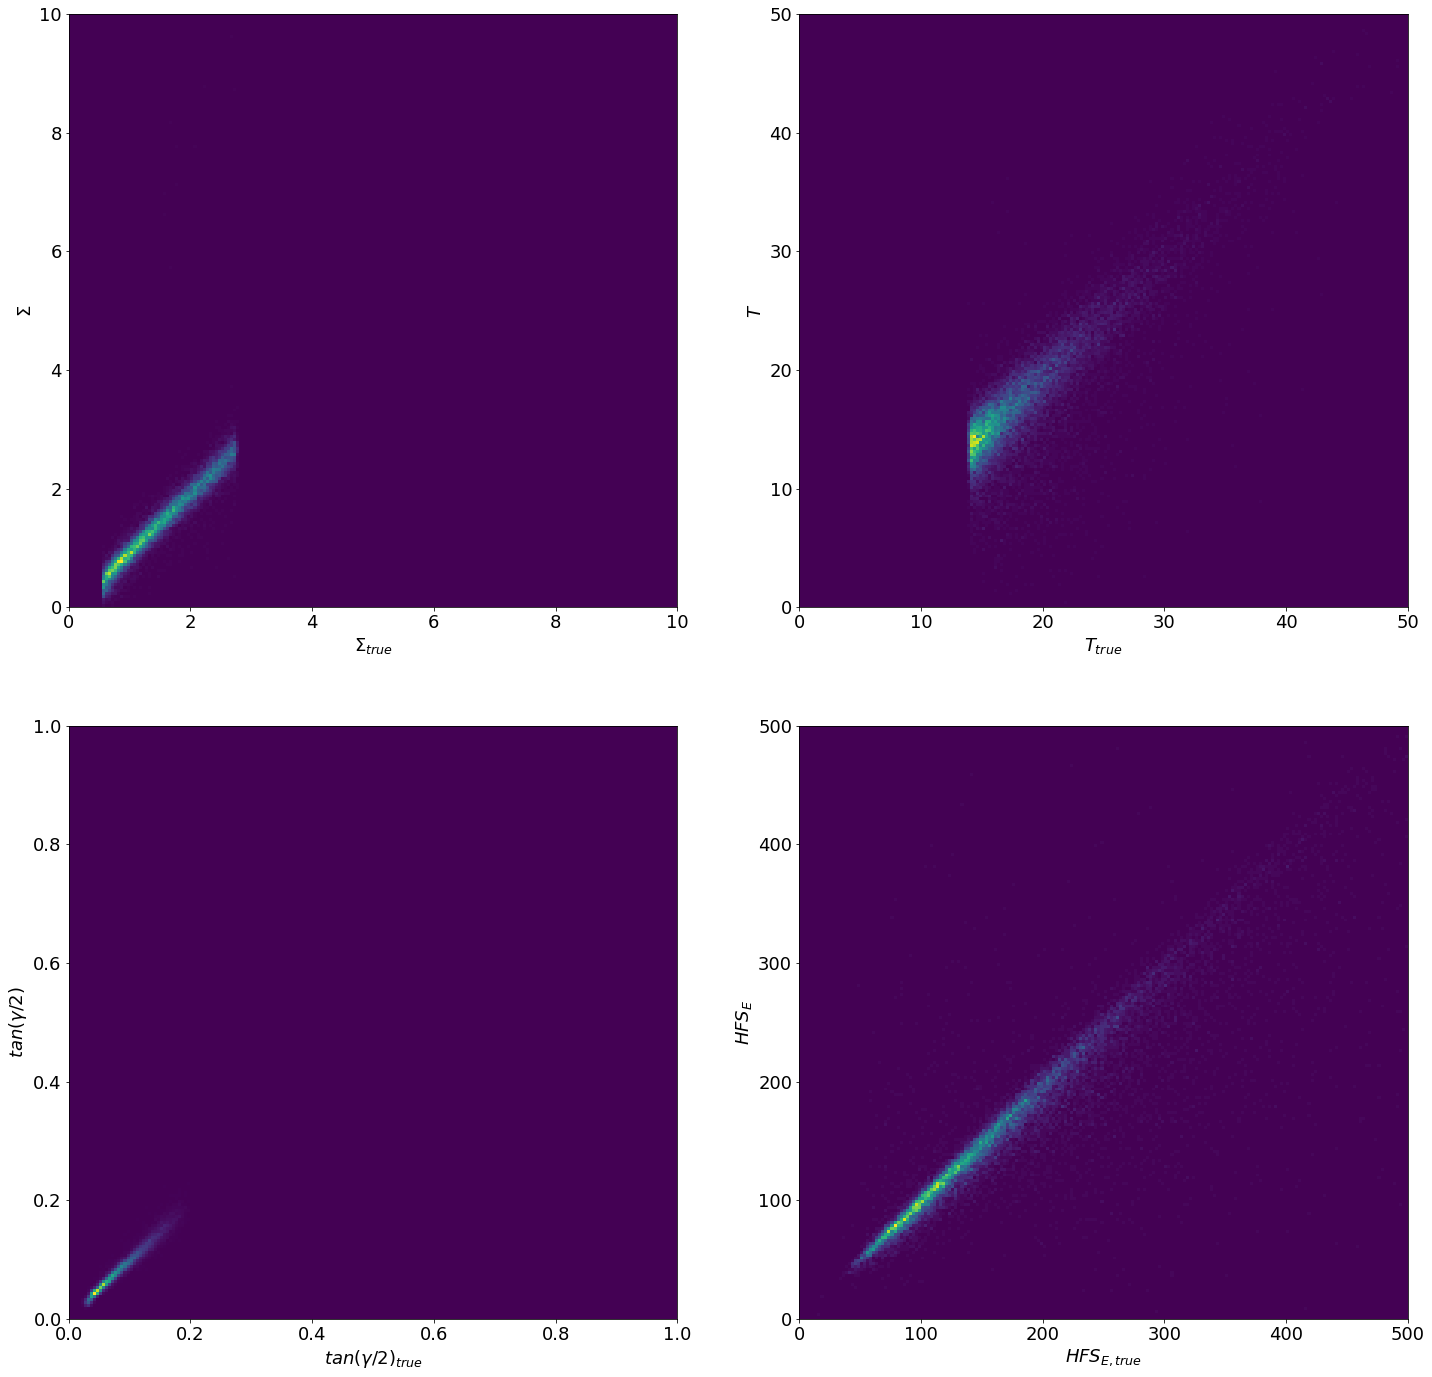

In [5]:
fig,ax = plt.subplots(2,2,figsize=(24,24))

ax[0][0].hist2d( mc.query(cuts)['Sigma__gen_e'], mc.query(cuts)['Sigma__HFS'], range=([0,10],[0,10]), bins=200)
ax[0][0].set_xlabel('$\Sigma_{true}$')
ax[0][0].set_ylabel('$\Sigma$')


ax[0][1].hist2d( mc.query(cuts)['T__gen_e'], mc.query(cuts)['T__HFS'], range=([0,50],[0,50]), bins=200)
ax[0][1].set_xlabel('$T_{true}$')
ax[0][1].set_ylabel('$T$')


ax[1][0].hist2d( mc.query(cuts)['tan_gamma_over_2__gen_e'], mc.query(cuts)['tan_gamma_over_2__HFS'], range=([0,1],[0,1]), bins=200)
ax[1][0].set_xlabel('$tan(\gamma/2)_{true}$')
ax[1][0].set_ylabel('$tan(\gamma/2)$')



ax[1][1].hist2d( mc.query(cuts)['gen_HFS_e'], mc.query(cuts)['HFS_E'], range=([0,500],[0,500]), bins=200)
ax[1][1].set_xlabel('$HFS_{E,true}$')
ax[1][1].set_ylabel('$HFS_E$')

plt.show()

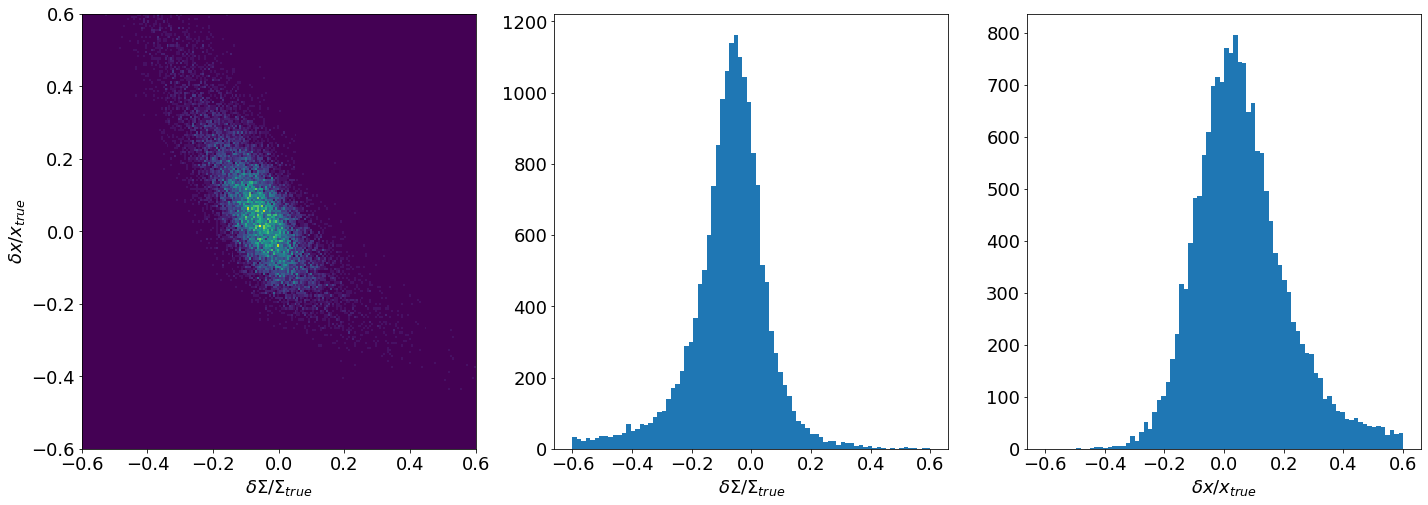

In [6]:
fix,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( mc.query(cuts)['dSigma_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
ax[0].set_xlabel('$\delta \Sigma / \Sigma_{true}$')
ax[0].set_ylabel('$\delta x / x_{true}$')


ax[1].hist( mc.query(cuts)['dSigma_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80 )
ax[1].set_xlabel('$\delta \Sigma / \Sigma_{true}$')

ax[2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
ax[2].set_xlabel('$\delta x / x_{true}$')

plt.show()

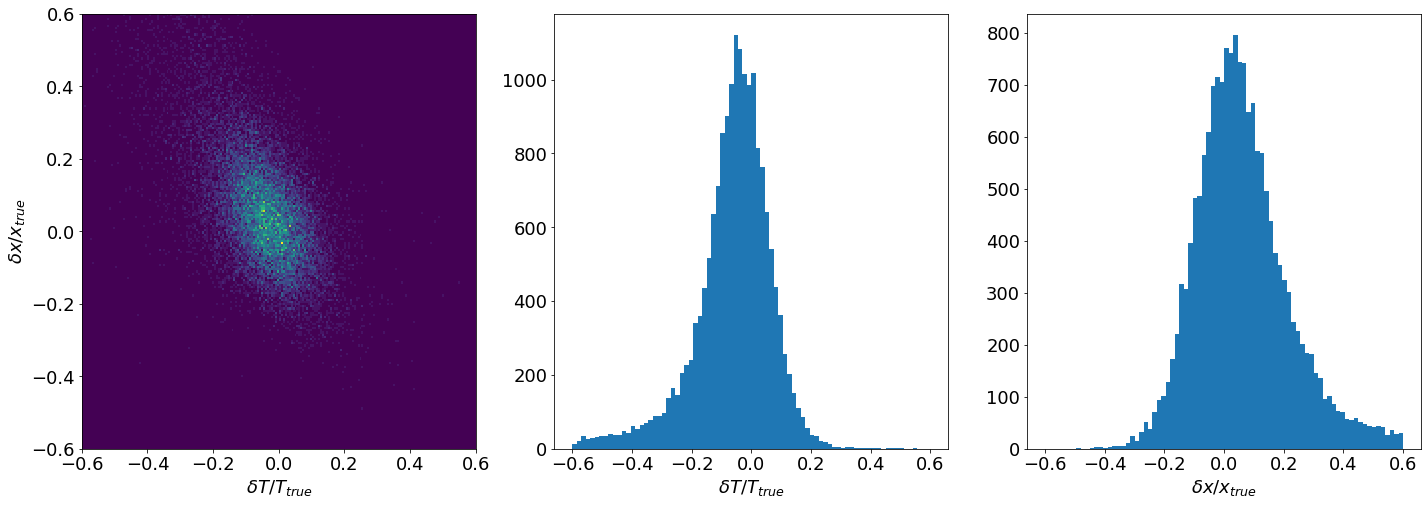

In [7]:
fix,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( mc.query(cuts)['dT_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
ax[0].set_xlabel('$\delta T / T_{true}$')
ax[0].set_ylabel('$\delta x / x_{true}$')

ax[1].hist( mc.query(cuts)['dT_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80 )
ax[1].set_xlabel('$\delta T / T_{true}$')

ax[2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
ax[2].set_xlabel('$\delta x / x_{true}$')

plt.show()

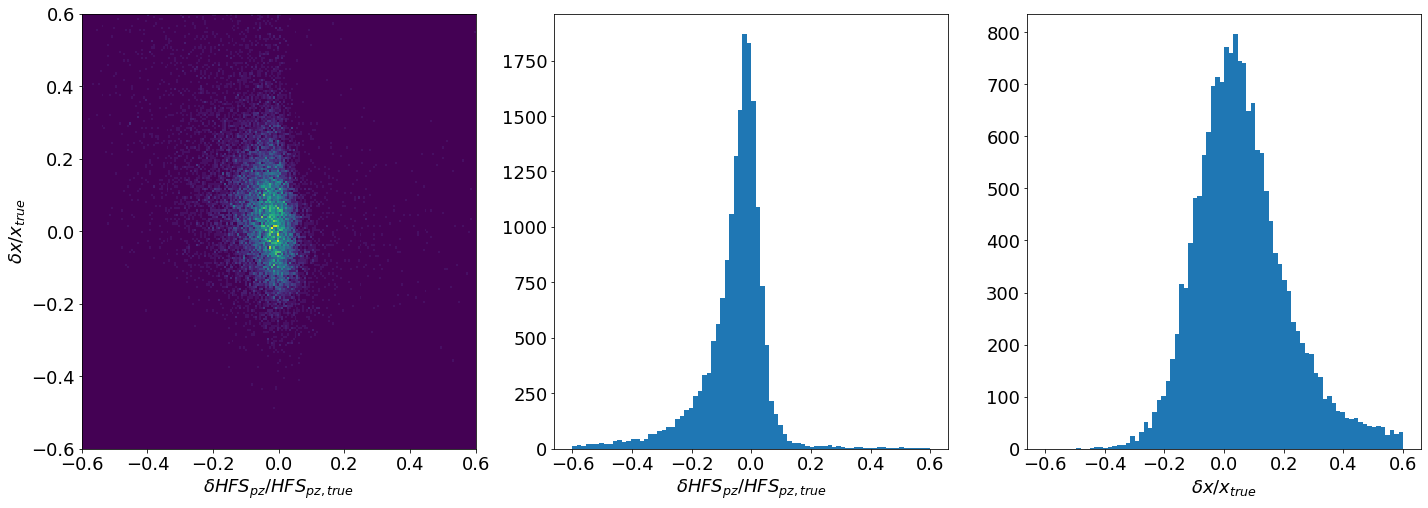

In [8]:
fix,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( mc.query(cuts)['dHFS_pz_norm__gen_HFS'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
ax[0].set_xlabel('$\delta HFS_{pz} / HFS_{pz,true}$')
ax[0].set_ylabel('$\delta x / x_{true}$')

ax[1].hist( mc.query(cuts)['dHFS_pz_norm__gen_HFS'], range=[-1*axis_max,axis_max], bins=80 )
ax[1].set_xlabel('$\delta HFS_{pz} / HFS_{pz,true}$')

ax[2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
ax[2].set_xlabel('$\delta x / x_{true}$')

plt.show()

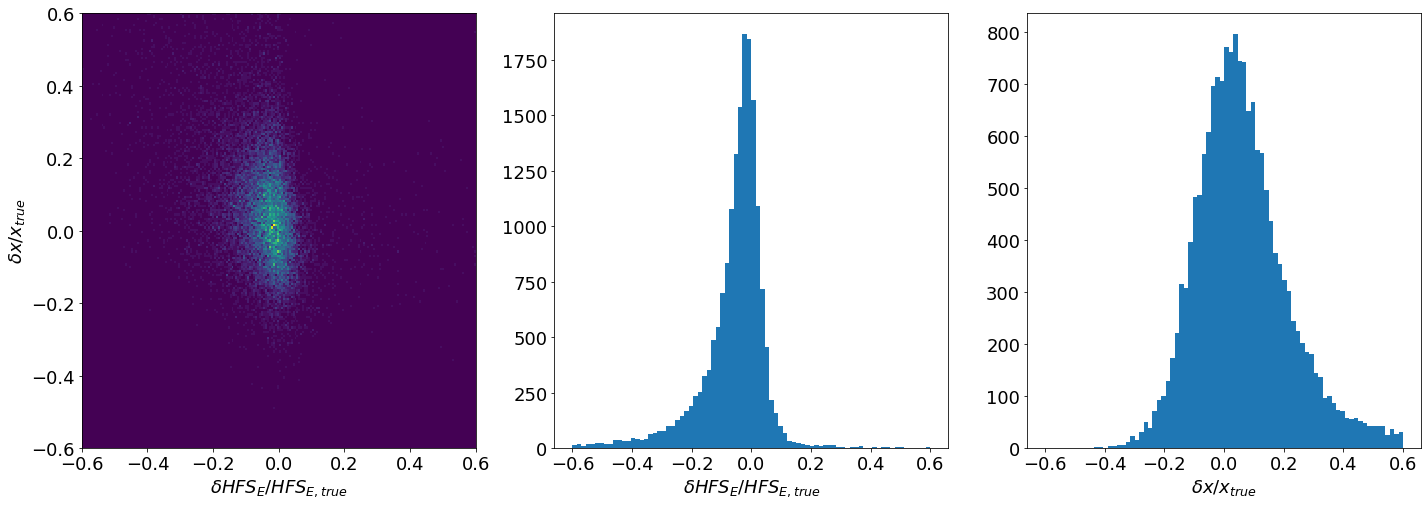

In [9]:
fix,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( mc.query(cuts)['dHFS_E_norm__gen_HFS'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
ax[0].set_xlabel('$\delta HFS_{E} / HFS_{E,true}$')
ax[0].set_ylabel('$\delta x / x_{true}$')

ax[1].hist( mc.query(cuts)['dHFS_E_norm__gen_HFS'], range=[-1*axis_max,axis_max], bins=80 )
ax[1].set_xlabel('$\delta HFS_{E} / HFS_{E,true}$')

ax[2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
ax[2].set_xlabel('$\delta x / x_{true}$')

plt.show()

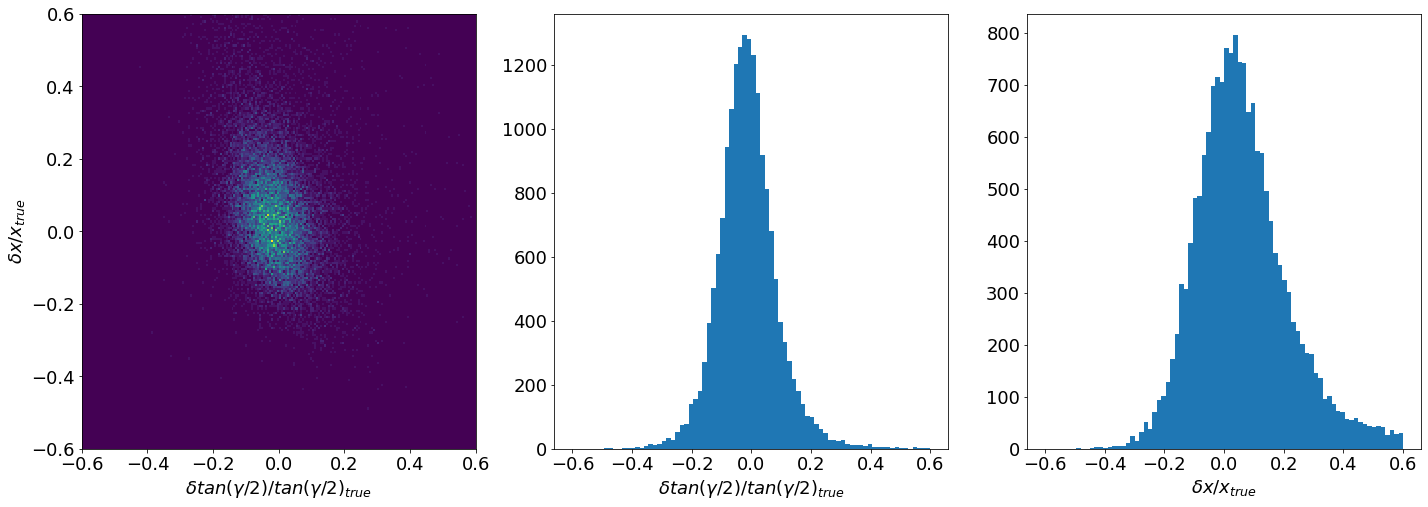

In [10]:
fix,ax = plt.subplots(1,3,figsize=(24,8))

ax[0].hist2d( mc.query(cuts)['dtan_gamma_over_2_norm__gen_e'], mc.query(cuts)['dx_sigma_norm'], range = ([-1*axis_max,axis_max],[-1*axis_max,axis_max]), bins=200)
ax[0].set_xlabel('$\delta tan(\gamma/2) / tan(\gamma/2)_{true}$')
ax[0].set_ylabel('$\delta x / x_{true}$')

ax[1].hist( mc.query(cuts)['dtan_gamma_over_2_norm__gen_e'], range=[-1*axis_max,axis_max], bins=80 )
ax[1].set_xlabel('$\delta tan(\gamma/2) / tan(\gamma/2)_{true}$')

ax[2].hist( mc.query(cuts)['dx_sigma_norm'], range=[-1*axis_max,axis_max], bins=80 )
ax[2].set_xlabel('$\delta x / x_{true}$')

plt.show()